# Explolation10
## 인물사진 만들기
### 딥러닝 모델기법중 하나인 세그멘테이션으로 사람만 따로 분리해보자.
### 필요한 모듈 불러오기

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### 사진 불러오기

[[[131 130 132]
  [148 147 149]
  [175 174 176]
  ...
  [  9   5  11]
  [  2   0   4]
  [ 11   7  13]]

 [[ 89  88  90]
  [125 124 126]
  [150 149 151]
  ...
  [ 72  68  74]
  [ 28  24  30]
  [  5   1   7]]

 [[145 144 146]
  [143 142 144]
  [123 122 124]
  ...
  [136 132 137]
  [119 115 120]
  [ 93  89  94]]

 ...

 [[163 164 160]
  [176 177 173]
  [177 174 170]
  ...
  [129 134 137]
  [134 138 143]
  [138 142 147]]

 [[167 168 164]
  [193 194 190]
  [206 203 199]
  ...
  [123 128 131]
  [123 127 132]
  [115 119 124]]

 [[170 171 167]
  [173 174 170]
  [168 165 161]
  ...
  [120 125 128]
  [121 125 130]
  [106 110 115]]]


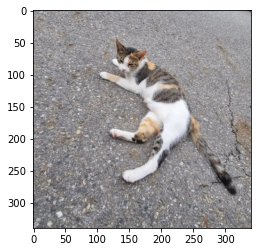

In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 이번 실습은 예상외로 간단하다 인물 누끼를따고, 배경누끼는 흐릿하게 따서, 둘이 합쳐주는 과정만하면된다.
### 일단 세그멘테이션모델을 다운받아 불러오자.

In [4]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f267d6ac940>)

### 이제 모델에 사진을 넣어보자. 총 21개로 분리로되어있는데 우리는 고양이누끼를 따야함으로 8번째인 행렬을 봐야한다.

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

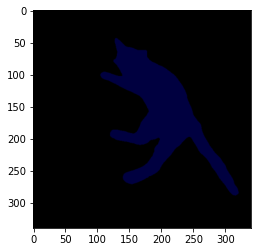

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

### 이렇게 결과를 보면 각기 다 다른행렬로 구분되어있다. 이제 8번째인 행렬을 확인해 그 행렬만 출력되게 바꾸면된다.

In [13]:
colormap[8]

array([64,  0,  0])

In [14]:
seg_color = (0,0,64)

(340, 340)


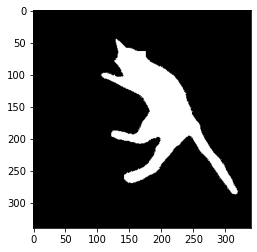

In [15]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

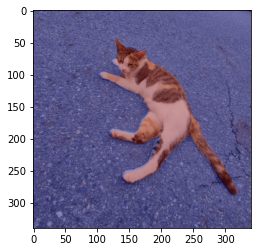

In [16]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 내가알던 누끼따는것과는 약간 다른점이 있지만 뒤에 배경이 파란걸보니 잘 딴것같다.
### 이제 사진을 흐리게 만들고 배경만 누끼따보도록하자. blur라는 메서드를써서 배경을 흐리게만들어준다.

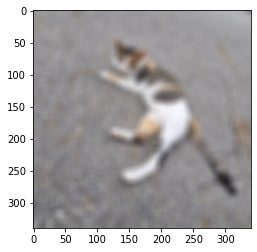

In [17]:
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

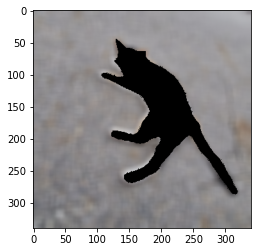

In [18]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 잘 따준모습이다. 이제 둘이 합치기만하면 인물에 포커스를 맞춘 사진을 만들수있다.

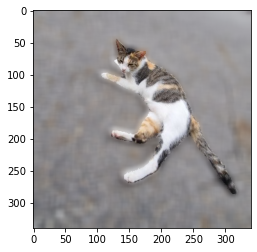

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 이제 인물을 포커싱해보자.

### 사진불러오기.

[[[249 246 248]
  [249 246 248]
  [249 246 248]
  ...
  [252 250 250]
  [252 250 250]
  [252 250 250]]

 [[249 246 248]
  [249 246 248]
  [249 246 248]
  ...
  [252 250 250]
  [252 250 250]
  [252 250 250]]

 [[249 246 248]
  [249 246 248]
  [249 246 248]
  ...
  [252 250 250]
  [252 250 250]
  [252 250 250]]

 ...

 [[110 113 118]
  [220 220 226]
  [228 228 234]
  ...
  [ 85  83  89]
  [ 65  63  62]
  [ 51  47  46]]

 [[153 155 163]
  [224 226 234]
  [232 232 238]
  ...
  [208 204 210]
  [178 173 175]
  [ 92  87  89]]

 [[184 186 194]
  [225 227 235]
  [234 234 240]
  ...
  [212 205 212]
  [206 199 206]
  [179 173 178]]]


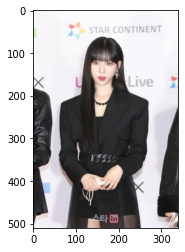

In [20]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/winterzz.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 모델에 사진넣기

In [21]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [22]:
segvalues, output = model.segmentAsPascalvoc(img_path)

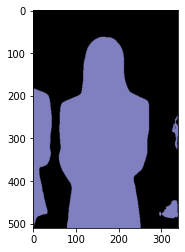

In [23]:
plt.imshow(output)
plt.show()

### 이번엔 사람이므로 15번행렬을 봐야한다

In [24]:
colormap[15]

array([192, 128, 128])

In [25]:
seg_color = (128,128,192)

(510, 340)


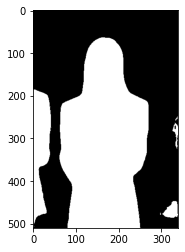

In [27]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

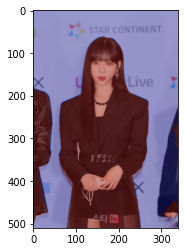

In [28]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 잘됐으니 이제 배경을 흐리게만들어주자.

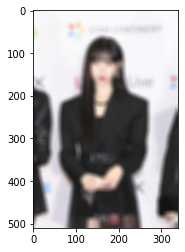

In [29]:
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

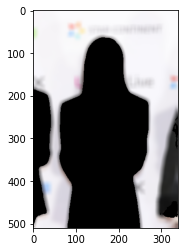

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 이제 합쳐주자.

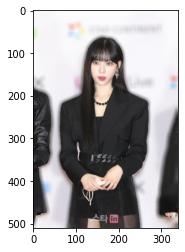

In [31]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 잘 된것같다. 하지만 옆에 옷들도 같이 포커스가된 모습이다. 이결해결할 수 있는 방법이 무엇이있을까? 필자는 세그멘테이션을 한번 사용한 뒤, 그 부분적인 부분에서의 분류를 위해  학습된 세그멘테이션을 사용해 그 안에서 분류를할수있게 만들면 가능할지않을까 생각한다.


### 이것으로 explolation10과제를 마친다.